# **Proyecto 1**
### **Integrantes:**
* Maria Camila Parra Díaz (201819464)
* Esteban Emmanuel Ortiz Morales (201913613)  
* Sergio Julian Zona Moreno (201914936)

# **Carga y muestreo de los datos**

In [1]:
# Importación de librerias
seed = 161
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport
import re, string, unicodedata

# Se importa la librería de tiempo para medir cuánto se demora en encontrar los hiperparámetros con cada modelo.
import time
import math
  
# Librerías de nltk que serán utilizadas.
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 

# Preprocesamiento de texto.
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# Pipelines y preprocesamiento de datos.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelos.
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Para búsqueda de hiperparámetros
from sklearn.model_selection import train_test_split,GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
# Balanceo
from imblearn.over_sampling import SMOTE

# Métricas para evaluar el modelo
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

# Gráficos
import matplotlib.pyplot as plt

# Importar/Exportar modelos
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shark\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shark\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shark\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Obtención del muestreo**

In [2]:
# Se cargan el conjunto total de los datos. 

start_time = time.time()
df_tweets=pd.read_csv('mbsa.csv', sep=',', encoding = 'utf-8', index_col=None)

# Se reemplazan los espacios de los nombres de las columnas por ''.
df_tweets.columns = df_tweets.columns.str.replace(' ', '')

# En promedio demora cargando 2-6 minutos.
print("Tiempo que demora cargando el conjunto de datos total: %.2f" % (time.time() - start_time))

Tiempo que demora cargando el conjunto de datos total: 92.58


In [3]:
# Cantidad de datos y número de variables
df_tweets.shape

(19344048, 3)

In [4]:
# Ejemplo de muestra de los datos.
df_tweets.sample(5)

,Date,text,Sentiment
18319053,2019-11-06,Alchemy.....恐るべし……。\nQFpay………恐るべし……。\nACD…………恐...,Positive
16297369,2019-10-03,Investment Firm Files Prospectus for New BTC F...,Negative
16320179,2019-10-04,Out for +3R thank you\n\n$BTC https://t.co/dkA...,Negative
18209325,2019-11-04,@jeronimorubio16 @DTube_Official @OneLoveDTube...,Positive
9766171,2019-07-11,$EPAZ's Bitcoin Sharing &amp; Blockchain Socia...,NaN


In [5]:
# Tipos de las variables al cargar, todas son objetos.
df_tweets.dtypes

Date         object
text         object
Sentiment    object
dtype: object

In [6]:
# Se cuentan los valores nulos en cada una de las columnas.
df_tweets.isnull().sum().sort_values()

Date              0
text             16
Sentiment    891144
dtype: int64

<BarContainer object of 3 artists>

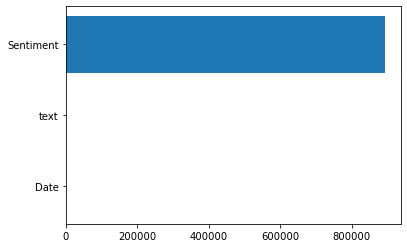

In [7]:
# Existen múltiples filas con valores nulos. Más adelante se depurarán dichos valores.
df_plot = df_tweets.isnull().sum().sort_values() # Número de valores nulos en filas.
plt.barh(df_plot.index, df_plot.values)

<BarContainer object of 3 artists>

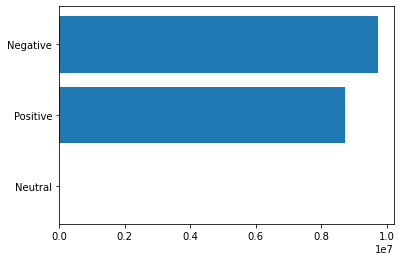

In [8]:
# Distribución de sentimientos en el DF original.
df_plot = df_tweets['Sentiment'].value_counts().sort_values() # Número de sentimientos positivos y negativos.
plt.barh(df_plot.index, df_plot.values)

In [9]:
# TIPO DE DEPURACIÓN: 
# Se eliminan valores no alfanuméricos de nuestro alfabeto como punto de partida de la depuración.
start_time = time.time()

# Se crea una copia 
df_tweets = df_tweets.copy();

# Se eliminan los valores nulos del DF.
df_tweets.dropna(inplace=True);

# Se eliminan todos aquellos Tweets no alfanuméricos.
df_tweets =  df_tweets.loc[df_tweets['text'].str.contains('^[a-zA-Z0-9!@#$&()\\-`.+,/\" \n\t]*$')]

# En promedio demora 2-3 min
print("Tiempo que demora depurando el conjunto de datos: %.2f" % (time.time() - start_time))

Tiempo que demora depurando el conjunto de datos: 83.68


In [11]:
# Tamaño y dimensiones del muestreo.
df_tweets.shape

(2530109, 3)

In [12]:
# Ejemplo del DF
df_tweets.sample(5)

,Date,text,Sentiment
16746196,2019-10-11,#ico #crypto #bitcoin #ethereum #blockchain #b...,Negative
10777366,2019-07-16,@cryptomanran Much better buy @Securypto\n#Sec...,Negative
12984193,2019-08-14,@Drone90210 Your right for sure but also there...,Negative
7137218,2019-06-14,@CharlieShrem Let them burn themselves. More B...,Positive
7773320,2019-06-22,#BTC,Positive


In [13]:
# Si se desmarca esta línea, se genera otro muestreo aleatorio. Se recomienda dejarla en el estado actual.
# df_tweets = df_tweets_c.sample(20000)

In [2]:
# Se efectua un sub-muestreo aleatorio para poder procesar los datos en un tiempo razonable.
# Se cargan los datos del muestreo para no generar valores aleatorios cada vez que se inicialice el cuadernillo.

start_time = time.time()
df_tweets=pd.read_csv('muestreo_20000.csv', sep=',', encoding = 'utf-8', index_col=None)

# Se reemplazan los espacios de los nombres de las columnas por ''.
df_tweets.columns = df_tweets.columns.str.replace(' ', '')

# En promedio demora cargando 2-10 seg.
print("Tiempo que demora cargando el muestreo: %.2f" % (time.time() - start_time))

df_tweets

Tiempo que demora cargando el muestreo: 0.07


,Unnamed:0,Unnamed:0,Date,text,Sentiment
0,0,18288115,2019-11-05,@Bebafuentes @WixhoHdez,Negative
1,1,4390944,2015-02-21,"In the last 10 mins, there were arb opps spann...",Positive
2,2,8970171,2019-07-04,"In 2017 we got ""hodl""\nIn 2017, we got the ""I ...",Negative
3,3,13822304,2019-08-27,Has more utility than $BTC,Negative
4,4,10095049,2019-07-12,@realDonaldTrump Bitcoin will be at all time h...,Positive
...,...,...,...,...,...
19995,19995,10104825,2019-07-13,@orangedog21 @marketvoyeur @MericanHodl @APOST...,Negative
19996,19996,15208742,2019-09-17,system maintenance.,Negative
19997,19997,6122321,2019-06-02,BSV convincing people they da real BTC,Positive
19998,19998,4542564,2016-01-31,"In the last 10 mins, there were arb opps spann...",Negative


In [3]:
# Exportamos en un .CSV el conjunto de datos preprocesado. Esto para no tener que efectuar el proceso cada vez que se
# inicie el cuadernillo. Esta linea se deja comentada, en caso de que se cambie el muestreo, se recomienda guardar 
# nuevamente el conjunto de datos para no perder el muestreo.
# df_tweets.to_csv("muestreo_20000.csv", sep=',', encoding='utf-8')

<BarContainer object of 2 artists>

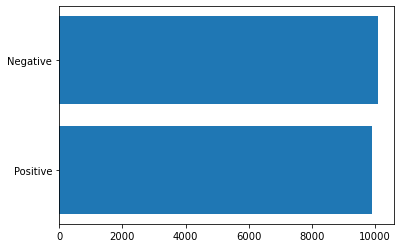

In [4]:
df_plot = df_tweets['Sentiment'].value_counts().sort_values() # Número de sentimientos positivos y negativos.
plt.barh(df_plot.index, df_plot.values)

# Nuestro muestreo es relativamente adecuado, aproximadamente la mitad de los sentimientos son positivos y la otra 
# mitad negativos. Una distribución similar al DF original.

# **Perfilamiento y entendimiento de los datos**
Obtendremos estadísticas descriptivas pertinentes y posteriormente ingresaremos el conjunto de datos a Pandas Profiling para obtener un reporte adecuado de correlación e interacción entre variables.

In [5]:
df_tweets_copy = df_tweets.copy()
df_tweets_copy = df_tweets_copy.drop('Unnamed:0',1)

# Obtención de estadísticas descriptivas.
start_time = time.time()

df_tweets_copy['Conteo'] = [len(x) for x in df_tweets_copy['text']]
df_tweets_copy['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in df_tweets_copy['text']]
df_tweets_copy['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in df_tweets_copy['text']]
df_tweets_copy['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in df_tweets_copy['text']]

# En promedio demora 1-5 seg.
print("Tiempo que demora obteniendo estadísticas descriptivas: %.2f" % (time.time() - start_time))

Tiempo que demora obteniendo estadísticas descriptivas: 0.40


In [6]:
df_tweets_copy.sample(10)

,Date,text,Sentiment,Conteo,Moda,Max,Min
12392,2018-04-04,0x7fd4B5f3c255ad0B60487ad412C1e924e410D276\n@a...,Negative,198,#Ethereum,56,4
6058,2019-01-18,"El precio del #BTC $3,676.73 USD #bitcoin #cri...",Negative,56,precio,14,2
19220,2019-07-11,Jerome Powell hace caer al bitcoin,Negative,35,,7,0
8560,2019-06-27,@algahim @abbcfoundation @Bitcoin @ethereum @D...,Negative,195,will,15,2
16919,2019-11-23,#Bitcoin is a hedge against current micro envi...,Positive,90,against,11,1
15806,2018-08-03,@lifeoncoin,Negative,11,@lifeoncoin,11,11
11990,2019-08-30,@sploofeek @parcofuka58 To hide your Btc,Positive,40,To,12,2
11906,2019-01-22,Im trynna own 1 whole bitcoin by May,Positive,37,,7,0
13900,2018-08-03,@lifeoncoin,Negative,11,@lifeoncoin,11,11
2036,2019-05-11,#QuarkChain #QKC #Blockchain #BTC #ETH #blockc...,Positive,70,#sharding,21,4


In [7]:
# Se genera un reporte de analítica. Demora menos de 1 minuto aproximadamente.
ProfileReport(df_tweets_copy)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **Perfilamiento y entendimiento de los datos**

## **Limpieza de los datos**

In [8]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
    
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [9]:
start_time = time.time()

df_tweets_copy['text'] = df_tweets_copy['text'].apply(contractions.fix) #Aplica la corrección de las contracciones

# En promedio demora 1-5 seg.
print("Tiempo que demora corrigiendo las contracciones: %.2f" % (time.time() - start_time))

Tiempo que demora corrigiendo las contracciones: 0.44


In [10]:
start_time = time.time()

df_tweets_copy['words'] = df_tweets_copy['text'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido

# En promedio demora 1-3 min.
print("Tiempo que demora preprocesando el texto: %.2f" % (time.time() - start_time))

Tiempo que demora preprocesando el texto: 92.25


In [11]:
df_tweets_copy.sample(5)

,Date,text,Sentiment,Conteo,Moda,Max,Min,words
5124,2019-05-11,@LucidInvestment When BTC is 50k this boomer w...,Positive,87,is,16,2,"[lucidinvestment, btc, 50k, boomer, still, say..."
4869,2018-08-03,@eztechwin,Negative,10,@eztechwin,10,10,[eztechwin]
12875,2018-08-03,@lifeoncoin,Negative,11,@lifeoncoin,11,11,[lifeoncoin]
2916,2019-10-12,Joules instead of red blood cells,Positive,33,Joules,7,2,"[joules, instead, red, blood, cells]"
10614,2019-05-12,nice,Negative,4,nice,4,4,[nice]


## **Normalización**

In [12]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [13]:
start_time = time.time()

# Aplica lematización y eliminación de pefijos y sufijos.
df_tweets_copy['words'] = df_tweets_copy['words'].apply(stem_and_lemmatize) 

df_tweets_copy.to_csv("muestreo_lemmatize.csv", sep=',', encoding='utf-8')

# Demora aproximadamente 10-20 seg.
print("Tiempo que demora efectuando la función 'stem_and_lemmatize': %.2f" % (time.time() - start_time))

Tiempo que demora efectuando la función 'stem_and_lemmatize': 7.81


In [14]:
df_tweets_copy.sample(5)

,Date,text,Sentiment,Conteo,Moda,Max,Min,words
14260,2019-11-20,#MnsAirDrop #MonnosAirDrop,Negative,26,#MnsAirDrop,14,11,"[mnsairdrop, monnosairdrop, mnsairdrop, monnos..."
12299,2019-06-15,#mining with follow #Fastcoin #Emerald #GameCr...,Positive,134,#Emerald,12,4,"[min, follow, fastcoin, emerald, gamecredit, v..."
1935,2019-06-26,Again buy bitcoin or ask me how to !,Positive,36,bitcoin,7,1,"[buy, bitcoin, ask, buy, bitcoin, ask]"
4699,2019-10-28,@Anthspeak bitcoin,Negative,18,@Anthspeak,10,7,"[anthspeak, bitcoin, anthspeak, bitcoin]"
1803,2019-10-06,bitcoin changed my life,Negative,23,life,7,2,"[bitcoin, chang, lif, bitcoin, change, life]"


## **Mensaje procesado**

In [15]:
start_time = time.time()
df_tweets_copy['processed_message'] = df_tweets_copy['words'].apply(lambda x: ' '.join(map(str, x)))

# En promedio demora 1-2 min.
print("Tiempo que demora procesando el mensaje: %.2f" % (time.time() - start_time))

Tiempo que demora procesando el mensaje: 0.09


In [16]:
df_tweets_copy

,Date,text,Sentiment,Conteo,Moda,Max,Min,words,processed_message
0,2019-11-05,@Bebafuentes @WixhoHdez,Negative,23,@WixhoHdez,12,10,"[bebafu, wixhohdez, bebafuentes, wixhohdez]",bebafu wixhohdez bebafuentes wixhohdez
1,2015-02-21,"In the last 10 mins, there were arb opps spann...",Positive,137,last,9,2,"[last, ten, min, arb, op, span, twentytwo, exc...",last ten min arb op span twentytwo exchang pai...
2,2019-07-04,"In 2017 we got ""hodl""\nIn 2017, we got the ""I ...",Negative,81,got,12,2,"[two thousand and seventeen, got, hodl, two th...",two thousand and seventeen got hodl two thousa...
3,2019-08-27,Has more utility than $BTC,Negative,26,Has,7,3,"[util, btc, utility, btc]",util btc utility btc
4,2019-07-12,@realDonaldTrump Bitcoin will be at all time h...,Positive,62,highs,16,2,"[realdonaldtrump, bitcoin, tim, high, soon, en...",realdonaldtrump bitcoin tim high soon enough r...
...,...,...,...,...,...,...,...,...,...
19995,2019-07-13,@orangedog21 @marketvoyeur @MericanHodl @APOST...,Negative,74,@orangedog21,16,2,"[orangedog21, marketvoy, mericanhodl, apostol1...",orangedog21 marketvoy mericanhodl apostol11778...
19996,2019-09-17,system maintenance.,Negative,19,maintenance.,12,6,"[system, maint, system, maintenance]",system maint system maintenance
19997,2019-06-02,BSV convincing people they da real BTC,Positive,38,they,10,2,"[bsv, convint, peopl, da, real, btc, bsv, conv...",bsv convint peopl da real btc bsv convince peo...
19998,2016-01-31,"In the last 10 mins, there were arb opps spann...",Negative,135,last,8,2,"[last, ten, min, arb, op, span, seventeen, exc...",last ten min arb op span seventeen exchang pai...


## **Adición del precio según fecha**

In [17]:
# Se cargan los datos. 

start_time = time.time()
df_price=pd.read_csv('coin_Bitcoin.csv', sep=',', encoding = 'utf-8', index_col=None)

# Se reemplazan los espacios de los nombres de las columnas por ''.
df_price.columns = df_price.columns.str.replace(' ', '')

# En promedio demora cargando 1-5 seg.
print("Tiempo que de carga de los datos: %.2f" % (time.time() - start_time))

df_price

Tiempo que de carga de los datos: 0.02


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02,33939.588700,32770.680780,33549.600180,33897.048590,3.872897e+10,6.354510e+11
2987,2988,Bitcoin,BTC,2021-07-03,34909.259900,33402.696540,33854.421360,34668.548400,2.438396e+10,6.499400e+11
2988,2989,Bitcoin,BTC,2021-07-04,35937.567150,34396.477460,34665.564870,35287.779770,2.492431e+10,6.615750e+11
2989,2990,Bitcoin,BTC,2021-07-05,35284.344430,33213.661030,35284.344430,33746.002460,2.672155e+10,6.326960e+11


In [29]:
df_bitcoin = df_tweets_copy.merge(df_price, on='Date')

# Se eliminan las columnas innecesarias.
df_bitcoin = df_bitcoin.drop('SNo',1)
df_bitcoin = df_bitcoin.drop('Name',1)
df_bitcoin = df_bitcoin.drop('Symbol',1)
df_bitcoin = df_bitcoin.drop('Volume',1)
df_bitcoin = df_bitcoin.drop('Marketcap',1)

# Se eliminan las estadísticas descriptivas.
df_bitcoin = df_bitcoin.drop('Moda',1)
df_bitcoin = df_bitcoin.drop('Max',1)
df_bitcoin = df_bitcoin.drop('Min',1)
df_bitcoin = df_bitcoin.drop('Conteo',1)
df_bitcoin = df_bitcoin.drop('text',1)
df_bitcoin = df_bitcoin.drop('words',1)

# Se imprime el DF final.
df_bitcoin['percentage_variation'] = ((df_bitcoin['Close']-df_bitcoin['Open'])/df_bitcoin['Open'])*100
df_bitcoin

,Date,Sentiment,processed_message,High,Low,Open,Close,percentage_variation
0,2019-11-05,Negative,bebafu wixhohdez bebafuentes wixhohdez,9457.418435,9256.932015,9413.004943,9342.527179,-0.748728
1,2019-11-05,Negative,altcoindailyio ev put licens plat cov read 320...,9457.418435,9256.932015,9413.004943,9342.527179,-0.748728
2,2019-11-05,Negative,realshoaibmalik thekevinsteel quoctua75163518 ...,9457.418435,9256.932015,9413.004943,9342.527179,-0.748728
3,2019-11-05,Negative,trustlessst six bil bitcoin trustlessstate six...,9457.418435,9256.932015,9413.004943,9342.527179,-0.748728
4,2019-11-05,Negative,trustmarkethub tmh blockchain p2p trustmarketh...,9457.418435,9256.932015,9413.004943,9342.527179,-0.748728
...,...,...,...,...,...,...,...,...
19995,2017-11-25,Positive,cur pric bitcoin 870000 current price bitcoin ...,8790.919922,8191.149902,8241.709961,8790.919922,6.663787
19996,2016-05-22,Negative,last ten min arb op span nin exchang pair yiel...,443.427002,439.035004,443.217987,439.322998,-0.878798
19997,2015-03-12,Negative,on bitcoin wor 29479 bitstamp high 29795 low 2...,297.088013,292.412994,296.127014,294.354004,-0.598733
19998,2015-01-10,Negative,on bitcoin wor 27600 bitstamp high 30500 low 2...,288.127014,273.966003,287.303009,274.795990,-4.353250


In [30]:
def wentUp(x):
    if x>2.5:
        return 1
    elif x<-2.5:
        return -1
    else:
        return 0
cat_variables = df_bitcoin[['Sentiment']]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
df_bitcoin = pd.concat([df_bitcoin, cat_dummies], axis=1) 
df_bitcoin = df_bitcoin.drop('Sentiment', axis = 1) # Se elimina la columna Sentiment.

df_bitcoin['wentUp'] = df_bitcoin['percentage_variation'].apply(wentUp)

df_bitcoin = df_bitcoin.drop('High',1)
df_bitcoin = df_bitcoin.drop('Low',1)
df_bitcoin = df_bitcoin.drop('Open',1)
df_bitcoin = df_bitcoin.drop('Close',1)
df_bitcoin = df_bitcoin.drop('percentage_variation',1)
df_bitcoin = df_bitcoin.drop('Date',1)

df_bitcoin

,processed_message,Sentiment_Positive,wentUp
0,bebafu wixhohdez bebafuentes wixhohdez,0,0
1,altcoindailyio ev put licens plat cov read 320...,0,0
2,realshoaibmalik thekevinsteel quoctua75163518 ...,0,0
3,trustlessst six bil bitcoin trustlessstate six...,0,0
4,trustmarkethub tmh blockchain p2p trustmarketh...,0,0
...,...,...,...
19995,cur pric bitcoin 870000 current price bitcoin ...,1,1
19996,last ten min arb op span nin exchang pair yiel...,0,0
19997,on bitcoin wor 29479 bitstamp high 29795 low 2...,0,0
19998,on bitcoin wor 27600 bitstamp high 30500 low 2...,0,-1


In [28]:
# Se exportan los datos preprocesados que serán ingresados a los modelos de aprendizaje supervisado.
df_bitcoin.to_csv("muestreo_20000_preprocesado.csv", sep=',', encoding='utf-8')

In [21]:
#df_bitcoin=pd.read_csv('muestreo_20000_preprocesado.csv', sep=',', encoding = 'utf-8', index_col=None)

# Se reemplazan los espacios de los nombres de las columnas por ''.
#df_bitcoin.columns = df_bitcoin.columns.str.replace(' ', '')
#df_bitcoin = df_bitcoin.drop('Unnamed:0',1)
#df_bitcoin = df_bitcoin.dropna()
#df_bitcoin

# **Creación y aplicación de los modelos**

Implementaremos seis modelos de aprendizaje supervisado enfocados en el ámbito de clasificación. Dichos modelos son:
* K-nearest neighbors (KNN)
* Multinomial Naive Bayes
* Support Vector Machine
* Decision Tree
* Random Forest
* Logistic Regression

### **K-nearest neighbors (KNN)**

In [36]:
# Se efectua una última copia de trabajo para los modelos.
df_final_knn = df_bitcoin.copy()

selected_cols = ['processed_message', 'Sentiment_Positive']

X = df_final_knn[selected_cols].copy()
Y = df_final_knn['wentUp'].copy()
# Se efectúa la partición 80% training - 20% test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [69]:
# Se transforma la columna de processed mesage.
transformer = [('transformer', ColumnTransformer([("tf-id", TfidfVectorizer(), X.columns.get_loc('processed_message'))]))] 

# Balanceo con Smote a los datos.
balance = [('smote', SMOTE(random_state = seed))]

# Clasificador.
classifier = [('knn', KNeighborsClassifier())]

# Ensamble del modelo con Pipeline.
model_knn = Pipeline(transformer + balance + classifier)
model_knn

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tf-id', TfidfVectorizer(),
                                                  0)])),
                ('smote', SMOTE(random_state=161)),
                ('knn', KNeighborsClassifier())])

In [69]:
# Búsqueda de hiperparámetros.
particiones = KFold(n_splits=10, shuffle=True, random_state = seed)
n_neighbors = list(range(1,11))
param_grid = {'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
              'knn__n_neighbors':n_neighbors,
              'knn__weights': ['uniform', 'distance'] } 

# Se ajusta el modelo.
grid_selector = GridSearchCV(estimator = model_knn, # Modelo (pipeline).
                          param_grid = param_grid, # Parámetros.
                          scoring='f1_micro', # Metrica f1.
                          cv=particiones, # Esquema de particiones.
                          refit = True) # Reentrenar el modelo al finalizar.

# Parámetros del modelo.
pd.DataFrame(grid_selector.estimator.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,transformer
4,smote
5,knn
6,transformer__n_jobs
7,transformer__remainder
8,transformer__sparse_threshold
9,transformer__transformer_weights


In [70]:
# Selección del modelo con los mejores parámetros.
start_time = time.time()

grid_selector = grid_selector.fit(X,Y)
final_model = grid_selector.best_estimator_
final_model

# En promedio demora 15-20 min.
print("Tiempo de búsqueda de hiperparámetros (segundos): %.2f" % (time.time() - start_time))

Tiempo de búsqueda de hiperparámetros (segundos): 1636.73


In [ ]:
# Se reporta el F1-Score y los mejores atributos.
print('F1-Score Promedio: %.2f' % grid_selector.best_score_)
print('Mejores Atributos')
pd.DataFrame.from_dict(grid_selector.best_params_, orient='index')

F1-Score Promedio: 0.54
Mejores Atributos


,0
knn__metric,manhattan
knn__n_neighbors,3
knn__weights,distance


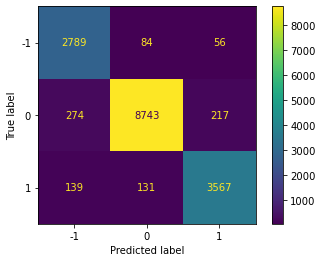

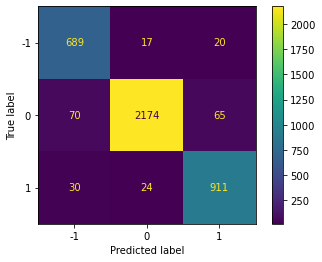

In [61]:
# Visualización de la matriz de confusión del training.
plot_confusion_matrix(final_model, X_train, Y_train)  

# Visualización de la matriz de confusión del test.
plot_confusion_matrix(final_model, X_test, Y_test)  

# La comparación de estas matrices nos permite identificar gráficamente si se presentan problemas de Overfitting.

In [62]:
# Reporte resumido
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Entrenamiento
print(classification_report(Y_train, y_pred_train))

# Test
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.87      0.95      0.91      2929
           0       0.98      0.95      0.96      9234
           1       0.93      0.93      0.93      3837

    accuracy                           0.94     16000
   macro avg       0.93      0.94      0.93     16000
weighted avg       0.95      0.94      0.94     16000

              precision    recall  f1-score   support

          -1       0.87      0.95      0.91       726
           0       0.98      0.94      0.96      2309
           1       0.91      0.94      0.93       965

    accuracy                           0.94      4000
   macro avg       0.92      0.94      0.93      4000
weighted avg       0.95      0.94      0.94      4000



In [65]:
# EXPORTAMOS EL MODELO: 
# Usamos la libreria joblib
filename = 'knn_model.joblib'
# Se guarda
dump(final_model, filename) 

['knn_model.joblib']

### **Multinomial Naive Bayes**

In [70]:
# Se efectua una última copia de trabajo para los modelos.
df_final_bayes = df_bitcoin.copy() 

selected_cols = ['processed_message', 'Sentiment_Positive']

X = df_final_bayes[selected_cols].copy()
Y = df_final_bayes['wentUp'].copy()
# Se efectúa la partición 80% training - 20% test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [71]:
# Se transforma la columna de processed mesage.
transformer = [('transformer', ColumnTransformer([("tf-id", TfidfVectorizer(), X.columns.get_loc('processed_message'))]))] 

# Balanceo con Smote a los datos.
balance = [('smote', SMOTE(random_state = seed))]

# Clasificador.
classifier = [('mnb', MultinomialNB())]

# Ensamble del modelo con Pipeline.
model_bayes = Pipeline(transformer + balance + classifier)
model_bayes

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tf-id', TfidfVectorizer(),
                                                  0)])),
                ('smote', SMOTE(random_state=161)), ('mnb', MultinomialNB())])

In [72]:
# Búsqueda de hiperparámetros.
particiones = KFold(n_splits=10, shuffle=True, random_state = seed)

param_grid = {'mnb__alpha': [0.00001,0.0001,0.001,0.01, 0.1, 1, 10, 100], 'mnb__fit_prior': [True, False]}

# Se ajusta el modelo.
grid_selector = GridSearchCV(estimator = model_bayes, # Modelo (pipeline).
                          param_grid = param_grid, # Parámetros.
                          scoring='f1_micro', # Metrica f1.
                          cv=particiones, # Esquema de particiones.
                          refit = True) # Reentrenar el modelo al finalizar.

# Parámetros del modelo.
pd.DataFrame(grid_selector.estimator.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,transformer
4,smote
5,mnb
6,transformer__n_jobs
7,transformer__remainder
8,transformer__sparse_threshold
9,transformer__transformer_weights


In [76]:
# Selección del modelo con los mejores parámetros.
start_time = time.time()

grid_selector = grid_selector.fit(X,Y)
final_model_bayes = grid_selector.best_estimator_
final_model_bayes

# En promedio demora 8-10 min.
print("Tiempo de búsqueda de hiperparámetros (segundos): %.2f" % (time.time() - start_time))

Tiempo de búsqueda de hiperparámetros (segundos): 198.27


In [79]:
# Se reporta el F1-Score y los mejores atributos.
print('F1-Score Promedio: %.2f' % grid_selector.best_score_)
print('Mejores Atributos')
pd.DataFrame.from_dict(grid_selector.best_params_, orient='index')

F1-Score Promedio: 0.56
Mejores Atributos


,0
mnb__alpha,10
mnb__fit_prior,True


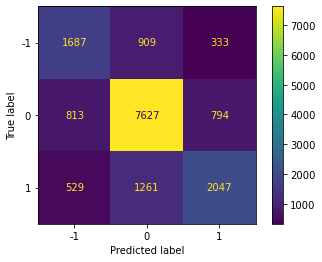

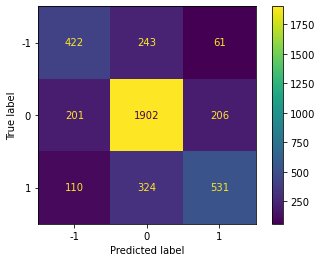

In [77]:
# Visualización de la matriz de confusión del training.
plot_confusion_matrix(final_model_bayes, X_train, Y_train)  

# Visualización de la matriz de confusión del test.
plot_confusion_matrix(final_model_bayes, X_test, Y_test)  

# La comparación de estas matrices nos permite identificar gráficamente si se presentan problemas de Overfitting.

In [78]:
# Reporte resumido
y_pred_train = final_model_bayes.predict(X_train)
y_pred_test = final_model_bayes.predict(X_test)

# Entrenamiento
print(classification_report(Y_train, y_pred_train))

# Test
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.56      0.58      0.57      2929
           0       0.78      0.83      0.80      9234
           1       0.64      0.53      0.58      3837

    accuracy                           0.71     16000
   macro avg       0.66      0.65      0.65     16000
weighted avg       0.71      0.71      0.71     16000

              precision    recall  f1-score   support

          -1       0.58      0.58      0.58       726
           0       0.77      0.82      0.80      2309
           1       0.67      0.55      0.60       965

    accuracy                           0.71      4000
   macro avg       0.67      0.65      0.66      4000
weighted avg       0.71      0.71      0.71      4000



In [80]:
# EXPORTAMOS EL MODELO: 
# Usamos la libreria joblib
filename = 'naive_bayes_model.joblib'
# Se guarda
dump(final_model_bayes, filename) 

['naive_bayes_model.joblib']

### **Support Vector Machine**

In [6]:
# Se efectua una última copia de trabajo para los modelos.
df_final_svc = df_bitcoin.copy() # Línea a modificar.

selected_cols = ['processed_message', 'Sentiment_Positive']

X = df_final_svc[selected_cols].copy()
Y = df_final_svc['wentUp'].copy()
# Se efectúa la partición 80% training - 20% test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [7]:
# Se transforman las columnas.
transformer = [('transformer', ColumnTransformer([("tf-id", TfidfVectorizer(), X.columns.get_loc('processed_message'))]))] 

# Balanceo con Smote a los datos.
balance = [('smote', SMOTE(random_state = seed))]

# Clasificador.
classifier = [('svc', SVC(random_state = seed))]

# Ensamble del modelo con Pipeline.
model_svc = Pipeline(transformer + balance + classifier)
model_svc

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tf-id', TfidfVectorizer(),
                                                  0)])),
                ('smote', SMOTE(random_state=161)),
                ('svc', SVC(random_state=161))])

In [8]:
# Búsqueda de hiperparámetros
particiones = KFold(n_splits=10, shuffle=True, random_state = seed)

C = list(range(1,11))
param_grid = {'svc__C':C,
              'svc__kernel':['linear','poly', 'rbf'],
              'svc__gamma' : ['scale','auto']} 

# Se ajusta el modelo.
grid_selector = GridSearchCV(estimator = model_svc, # Modelo (pipeline).
                          param_grid = param_grid, # Parámetros.
                          cv=particiones, # Esquema de particiones.
                          refit = True) # Reentrenar el modelo al finalizar.

# Parámetros del modelo.
pd.DataFrame(grid_selector.estimator.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,transformer
4,smote
5,svc
6,transformer__n_jobs
7,transformer__remainder
8,transformer__sparse_threshold
9,transformer__transformer_weights


In [56]:
# Selección del modelo con los mejores parámetros.
start_time = time.time()

grid_selector = grid_selector.fit(X,Y)
final_model = grid_selector.best_estimator_
final_model

# En promedio demora 5-6 horas.
print("Tiempo de búsqueda de hiperparámetros (segundos): %.2f" % (time.time() - start_time))

Tiempo de búsqueda de hiperparámetros (segundos): 158365.21


In [57]:
# Se reporta el F1-Score y los mejores atributos.
print('F1-Score Promedio: %.2f' % grid_selector.best_score_)
print('Mejores Atributos')
pd.DataFrame.from_dict(grid_selector.best_params_, orient='index')

F1-Score Promedio: 0.65
Mejores Atributos


,0
svc__C,1
svc__gamma,auto
svc__kernel,poly


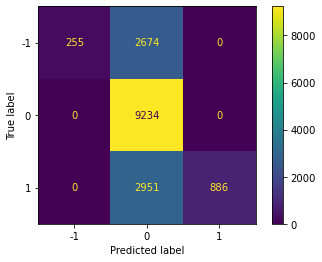

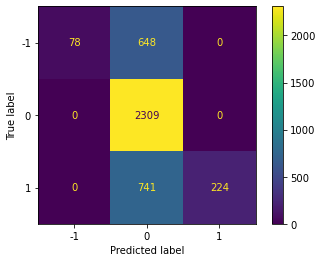

In [58]:
# Visualización de la matriz de confusión del training.
plot_confusion_matrix(final_model, X_train, Y_train)  
plt.show()

# Visualización de la matriz de confusión del test.
plot_confusion_matrix(final_model, X_test, Y_test)  
plt.show()

# La comparación de estas matrices nos permite identificar gráficamente si se presentan problemas de Overfitting.

In [59]:
# Reporte resumido
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Entrenamiento
print(classification_report(Y_train, y_pred_train))

# Test
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       1.00      0.09      0.16      2929
           0       0.62      1.00      0.77      9234
           1       1.00      0.23      0.38      3837

    accuracy                           0.65     16000
   macro avg       0.87      0.44      0.43     16000
weighted avg       0.78      0.65      0.56     16000

              precision    recall  f1-score   support

          -1       1.00      0.11      0.19       726
           0       0.62      1.00      0.77      2309
           1       1.00      0.23      0.38       965

    accuracy                           0.65      4000
   macro avg       0.87      0.45      0.45      4000
weighted avg       0.78      0.65      0.57      4000



In [61]:
# EXPORTAMOS EL MODELO: 
# Usamos la libreria joblib.
filename = 'svc_model.joblib'

# Se guarda
dump(final_model, filename) 

['svc_model.joblib']

### **Decision Tree**

In [65]:
# Se efectua una última copia de trabajo para los modelos.
df_final_tree = df_bitcoin.copy() # Línea a modificar.

selected_cols = ['processed_message', 'Sentiment_Positive']

X = df_final_tree[selected_cols].copy()
Y = df_final_tree['wentUp'].copy()
# Se efectúa la partición 80% training - 20% test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [66]:
# Se transforman las columnas.
transformer = [('transformer', ColumnTransformer([("tf-id", TfidfVectorizer(), X.columns.get_loc('processed_message'))]))] 

# Balanceo con Smote a los datos.
balance = [('smote', SMOTE(random_state = seed))]

# Clasificador.
classifier = [('tree', DecisionTreeClassifier(random_state = seed))]

# Ensamble del modelo con Pipeline.
model_tree = Pipeline(transformer + balance + classifier)
model_tree

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tf-id', TfidfVectorizer(),
                                                  0)])),
                ('smote', SMOTE(random_state=161)),
                ('tree', DecisionTreeClassifier(random_state=161))])

In [67]:
# Búsqueda de hiperparámetros
particiones = KFold(n_splits=10, shuffle=True, random_state = seed)

C = list(range(1,11))
param_grid = {'tree__criterion':['gini', 'entropy'],
              'tree__max_depth':[4,6,8,10],
              'tree__splitter' : ['best', 'random'],
              'tree__max_features': ['auto', 'sqrt', 'log2', None] } 

# Se ajusta el modelo.
grid_selector = GridSearchCV(estimator = model_tree, # Modelo (pipeline).
                          param_grid = param_grid, # Parámetros.
                          cv=particiones, # Esquema de particiones.
                          refit = True) # Reentrenar el modelo al finalizar.

# Parámetros del modelo.
pd.DataFrame(grid_selector.estimator.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,transformer
4,smote
5,tree
6,transformer__n_jobs
7,transformer__remainder
8,transformer__sparse_threshold
9,transformer__transformer_weights


In [68]:
# Selección del modelo con los mejores parámetros.
start_time = time.time()

grid_selector = grid_selector.fit(X,Y)
final_model = grid_selector.best_estimator_
final_model

# En promedio demora 3-4 horas.
print("Tiempo de búsqueda de hiperparámetros (segundos): %.2f" % (time.time() - start_time))

Tiempo de búsqueda de hiperparámetros (segundos): 1122.63


In [69]:
# Se reporta el F1-Score y los mejores atributos.
print('F1-Score Promedio: %.2f' % grid_selector.best_score_)
print('Mejores Atributos')
pd.DataFrame.from_dict(grid_selector.best_params_, orient='index')

F1-Score Promedio: 0.50
Mejores Atributos


,0
tree__criterion,entropy
tree__max_depth,10
tree__max_features,None
tree__splitter,best


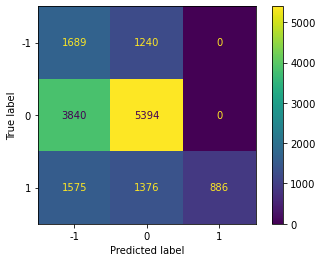

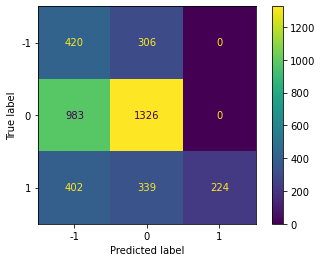

In [70]:
# Visualización de la matriz de confusión del training.
plot_confusion_matrix(final_model, X_train, Y_train)  
plt.show()

# Visualización de la matriz de confusión del test.
plot_confusion_matrix(final_model, X_test, Y_test)  
plt.show()

# La comparación de estas matrices nos permite identificar gráficamente si se presentan problemas de Overfitting.

In [71]:
# Reporte resumido
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Entrenamiento
print(classification_report(Y_train, y_pred_train))

# Test
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.24      0.58      0.34      2929
           0       0.67      0.58      0.63      9234
           1       1.00      0.23      0.38      3837

    accuracy                           0.50     16000
   macro avg       0.64      0.46      0.45     16000
weighted avg       0.67      0.50      0.51     16000

              precision    recall  f1-score   support

          -1       0.23      0.58      0.33       726
           0       0.67      0.57      0.62      2309
           1       1.00      0.23      0.38       965

    accuracy                           0.49      4000
   macro avg       0.64      0.46      0.44      4000
weighted avg       0.67      0.49      0.51      4000



In [72]:
# EXPORTAMOS EL MODELO: 
# Usamos la libreria joblib
filename = 'tree_model.joblib'
# Se guarda
dump(final_model, filename) 

['tree_model.joblib']

### **Random Forest**

In [48]:
# Se efectua una última copia de trabajo para los modelos.
df_final_forest = df_bitcoin.copy() # Línea a modificar.

selected_cols = ['processed_message', 'Sentiment_Positive']

X = df_final_forest[selected_cols].copy()
Y = df_final_forest['wentUp'].copy()
# Se efectúa la partición 80% training - 20% test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [49]:
# Se transforman las columnas.
transformer = [('transformer', ColumnTransformer([("tf-id", TfidfVectorizer(), X.columns.get_loc('processed_message'))]))] 

# Balanceo con Smote a los datos.
balance = [('smote', SMOTE(random_state = seed))]

# Clasificador.
classifier = [('forest', RandomForestClassifier(random_state = seed))]

# Ensamble del modelo con Pipeline.
model_forest = Pipeline(transformer + balance + classifier)
model_forest

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tf-id', TfidfVectorizer(),
                                                  0)])),
                ('smote', SMOTE(random_state=161)),
                ('forest', RandomForestClassifier(random_state=161))])

In [50]:
# Búsqueda de hiperparámetros
particiones = KFold(n_splits=10, shuffle=True, random_state = seed)

param_grid = {'forest__n_estimators':[100, 200],
              'forest__criterion':['gini','entropy'],
              'forest__max_depth' : [4,6,8,10]} 

# Se ajusta el modelo.
grid_selector = GridSearchCV(estimator = model_forest, # Modelo (pipeline).
                          param_grid = param_grid, # Parámetros.
                          cv=particiones, # Esquema de particiones.
                          refit = True) # Reentrenar el modelo al finalizar.

# Parámetros del modelo.
pd.DataFrame(grid_selector.estimator.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,transformer
4,smote
5,forest
6,transformer__n_jobs
7,transformer__remainder
8,transformer__sparse_threshold
9,transformer__transformer_weights


In [51]:
# Selección del modelo con los mejores parámetros.
start_time = time.time()

grid_selector = grid_selector.fit(X,Y)
final_model = grid_selector.best_estimator_
final_model

# En promedio demora 8-10 min.
print("Tiempo de búsqueda de hiperparámetros (segundos): %.2f" % (time.time() - start_time))

Tiempo de búsqueda de hiperparámetros (segundos): 489.28


In [52]:
# Se reporta el F1-Score y los mejores atributos.
print('F1-Score Promedio: %.2f' % grid_selector.best_score_)
print('Mejores Atributos')
pd.DataFrame.from_dict(grid_selector.best_params_, orient='index')

F1-Score Promedio: 0.54
Mejores Atributos


,0
forest__criterion,entropy
forest__max_depth,6
forest__n_estimators,200


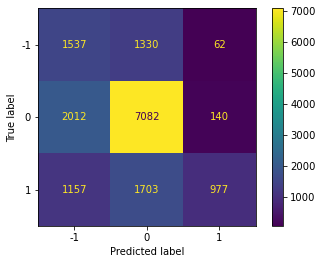

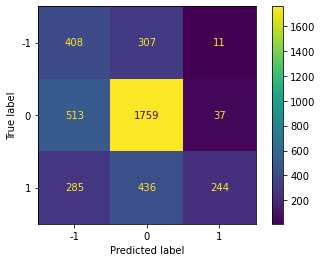

In [53]:
# Visualización de la matriz de confusión del training.
plot_confusion_matrix(final_model, X_train, Y_train)  
plt.show()

# Visualización de la matriz de confusión del test.
plot_confusion_matrix(final_model, X_test, Y_test)  
plt.show()

# La comparación de estas matrices nos permite identificar gráficamente si se presentan problemas de Overfitting.

In [54]:
# Reporte resumido
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Entrenamiento
print(classification_report(Y_train, y_pred_train))

# Test
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.33      0.52      0.40      2929
           0       0.70      0.77      0.73      9234
           1       0.83      0.25      0.39      3837

    accuracy                           0.60     16000
   macro avg       0.62      0.52      0.51     16000
weighted avg       0.66      0.60      0.59     16000

              precision    recall  f1-score   support

          -1       0.34      0.56      0.42       726
           0       0.70      0.76      0.73      2309
           1       0.84      0.25      0.39       965

    accuracy                           0.60      4000
   macro avg       0.63      0.53      0.51      4000
weighted avg       0.67      0.60      0.59      4000



In [64]:
# EXPORTAMOS EL MODELO: 
# Usamos la libreria joblib
filename = 'random_forest_model.joblib'
# Se guarda
dump(final_model, filename) 

['random_forest_model.joblib']

### **Logistic Regression**

In [56]:
# Se efectua una última copia de trabajo para los modelos.
df_final_regression = df_bitcoin.copy() # Línea a modificar.

selected_cols = ['processed_message', 'Sentiment_Positive']

X = df_final_regression[selected_cols].copy()
Y = df_final_regression['wentUp'].copy()
# Se efectúa la partición 80% training - 20% test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [57]:
# Se transforman las columnas.
transformer = [('transformer', ColumnTransformer([("tf-id", TfidfVectorizer(), X.columns.get_loc('processed_message'))]))] 

# Balanceo con Smote a los datos.
balance = [('smote', SMOTE(random_state = seed))]

# Clasificador.
classifier = [('regression', LogisticRegression(random_state = seed))]

# Ensamble del modelo con Pipeline.
model_regression = Pipeline(transformer + balance + classifier)
model_regression

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tf-id', TfidfVectorizer(),
                                                  0)])),
                ('smote', SMOTE(random_state=161)),
                ('regression', LogisticRegression(random_state=161))])

In [58]:
# Búsqueda de hiperparámetros
particiones = KFold(n_splits=10, shuffle=True, random_state = seed)

C = list(range(1,11))
param_grid = {'regression__C': [0.01, 0.1, 1, 10, 100],
                'regression__penalty': ['l2'],
                'regression__max_iter': list(range(100,800,200)),
                'regression__solver': ['newton-cg', 'liblinear'] } 

# Se ajusta el modelo.
grid_selector = GridSearchCV(estimator = model_regression, # Modelo (pipeline).
                          param_grid = param_grid, # Parámetros.
                          cv=particiones, # Esquema de particiones.
                          refit = True) # Reentrenar el modelo al finalizar.

# Parámetros del modelo.
pd.DataFrame(grid_selector.estimator.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,transformer
4,smote
5,regression
6,transformer__n_jobs
7,transformer__remainder
8,transformer__sparse_threshold
9,transformer__transformer_weights


In [59]:
# Selección del modelo con los mejores parámetros.
start_time = time.time()

grid_selector = grid_selector.fit(X,Y)
final_model = grid_selector.best_estimator_
final_model

# En promedio demora 15-30 min.
print("Tiempo de búsqueda de hiperparámetros (segundos): %.2f" % (time.time() - start_time))

Tiempo de búsqueda de hiperparámetros (segundos): 2851.55


In [60]:
# Se reporta el F1-Score y los mejores atributos.
print('F1-Score Promedio: %.2f' % grid_selector.best_score_)
print('Mejores Atributos')
pd.DataFrame.from_dict(grid_selector.best_params_, orient='index')

F1-Score Promedio: 0.54
Mejores Atributos


,0
regression__C,10
regression__max_iter,100
regression__penalty,l2
regression__solver,liblinear


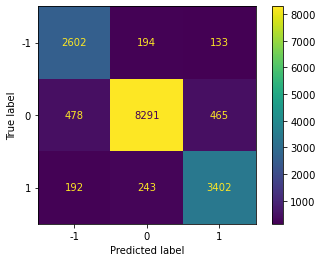

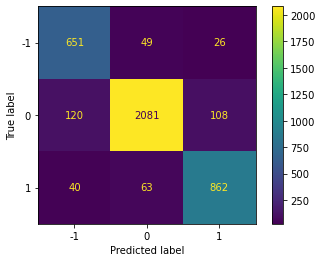

In [61]:
# Visualización de la matriz de confusión del training.
plot_confusion_matrix(final_model, X_train, Y_train)  
plt.show()

# Visualización de la matriz de confusión del test.
plot_confusion_matrix(final_model, X_test, Y_test)  
plt.show()

# La comparación de estas matrices nos permite identificar gráficamente si se presentan problemas de Overfitting.

In [62]:
# Reporte resumido
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Entrenamiento
print(classification_report(Y_train, y_pred_train))

# Test
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.80      0.89      0.84      2929
           0       0.95      0.90      0.92      9234
           1       0.85      0.89      0.87      3837

    accuracy                           0.89     16000
   macro avg       0.87      0.89      0.88     16000
weighted avg       0.90      0.89      0.89     16000

              precision    recall  f1-score   support

          -1       0.80      0.90      0.85       726
           0       0.95      0.90      0.92      2309
           1       0.87      0.89      0.88       965

    accuracy                           0.90      4000
   macro avg       0.87      0.90      0.88      4000
weighted avg       0.90      0.90      0.90      4000



In [63]:
# EXPORTAMOS EL MODELO: 
# Usamos la libreria joblib.
filename = 'logistic_model.joblib'
# Se guarda
dump(final_model, filename) 

['models/logistic_model.joblib']